In [21]:
import pandas as pd
import numpy as np
import seaborn as sns

from dpks import QuantMatrix

sns.set_theme(font="Arial", style="white", context="poster")

In [22]:
clinical_columns = [
    "sao2_ambulance",
    "resp_frequency_ambulance",
    "heart_rate_ambulance",
    "syst_bp_ambulance",
    "map_ambulance",
    "mental_status_ambulance", # categorical
    "temperature_ambulance",
    "crea_emergency_department",
    "bili_emergency_department",
    "crp_day1",
    "trc_emergency_department",
    "sex",
    "age"
]

continuous_clinical_columns = [
    "sao2_ambulance",
    "resp_frequency_ambulance",
    "heart_rate_ambulance",
    "syst_bp_ambulance",
    "map_ambulance",
    "temperature_ambulance",
    "crea_emergency_department",
    "bili_emergency_department",
    "trc_emergency_department",
    "crp_day1",
    "age"
]

categorical_clinical_columns = [
    "mental_status_ambulance",
]

selected_features = [
    'VWF_HUMAN',
    'CRP_HUMAN',
    'LBP_HUMAN',
    'B2MG_HUMAN',
    'VCAM1_HUMAN',
    'FIBG_HUMAN',
    'AACT_HUMAN',
    'IBP3_HUMAN',
    'THBG_HUMAN',
    'FGL1_HUMAN'
]

In [23]:

def preprocess_design_matrix(design_matrix):

    # design_matrix = design_matrix[
    #     ((design_matrix['Sepsis Diagnosis Probability'] >= 0.8) | 
    #     (design_matrix['Sepsis Diagnosis Probability'] <= 0.50))
    # ].copy()

    design_matrix['group'] = 1

    design_matrix['sample'] = design_matrix['injection']

    return design_matrix

In [24]:
def preprocess_data(raw_data, design_matrix):

    quant_matrix = QuantMatrix(
        quantification_file=raw_data[['Protein'] + [sample for sample in design_matrix['sample'].values]].copy(),
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    quant_data = quant_matrix.to_df()
    
    quant_data = quant_data[~((quant_data["ProteinLabel"].str.startswith("HV")) | (quant_data["ProteinLabel"].str.startswith("LV")) | quant_data["ProteinLabel"].str.startswith("KV"))]
    quant_data = quant_data[~quant_data["ProteinLabel"].str.startswith("IG")]
    quant_data = quant_data[~((quant_data["ProteinLabel"] == "HBA_HUMAN") | (quant_data["ProteinLabel"] == "HBB_HUMAN") | (quant_data["ProteinLabel"] == "HBD_HUMAN") | (quant_data["ProteinLabel"] == "HEMO_HUMAN"))]

    quant_matrix = QuantMatrix(
        quantification_file=quant_data,
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    return quant_matrix.annotate()     


In [25]:
ms_data = pd.read_csv(
    "../0_data/proteins_test_filtered.tsv"
    , sep="\t"
)

In [26]:
design_matrix_otrain = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

In [27]:
design_matrix_train = preprocess_design_matrix(design_matrix_otrain)

quant_matrix_train = preprocess_data(ms_data, design_matrix=design_matrix_train)

In [28]:
quant_matrix_train_df = quant_matrix_train.to_df()
quant_matrix_train_df = quant_matrix_train_df[quant_matrix_train_df['ProteinLabel'].isin(selected_features)]

In [29]:
qm_filtered_train = (
    
    QuantMatrix(
        quantification_file=quant_matrix_train_df,
        design_matrix_file=design_matrix_train
    )
    
)

In [30]:
training_data, y = qm_filtered_train.to_ml(feature_column="ProteinLabel")

In [31]:
X = training_data.copy()

X = X.copy()

In [32]:
X = X.join(
    design_matrix_train.set_index("injection")
)

In [33]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer


In [34]:


X = X.copy()

In [35]:
X_subset = X.copy()

In [36]:
ms_data_test = pd.read_csv(
    "../0_data/proteins_val_filtered.tsv"
    , sep="\t"
)
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_validation.tsv",
    sep='\t'
)

In [37]:
design_matrix_test = preprocess_design_matrix(design_matrix_test)

quant_matrix_test = preprocess_data(ms_data_test, design_matrix=design_matrix_test)

In [38]:
quant_matrix_test_df = quant_matrix_test.to_df()
quant_matrix_test_df = quant_matrix_test_df[quant_matrix_test_df['ProteinLabel'].isin(selected_features)]

In [39]:
qm_filtered_test = (
    
    QuantMatrix(
        quantification_file=quant_matrix_test_df,
        design_matrix_file=design_matrix_test
    )
    
)

In [40]:
testing_data, y_test = qm_filtered_test.to_ml(feature_column="ProteinLabel")

In [41]:
X_test = testing_data.copy()

X_test = X_test.copy()

In [42]:
X_test = X_test.join(
    design_matrix_test.set_index("injection")
)

In [43]:
from scipy import stats
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

def plot_results(X_input, bootstrap_data):

    bootstrap_counts = []


    for bootstrap_iteration in list(bootstrap_data.keys()):


        mort_range = X_input[bootstrap_iteration].unique()
        mort_range.sort()
        actual_mort = []
        #mort_range = mort_range[:-1]
        counts_per_bin = []
        for val in mort_range:

            counts = X_input[X_input[bootstrap_iteration] == val]['sepsis_or_septic_shock'].value_counts()
            actual_mort.append(counts.get(1, 0) / (counts.get(0, 0) + counts.get(1, 0)))
            counts_per_bin.append(counts.sum())

        estimated_mort = pd.DataFrame(
            {
                "Actual Sepsis Rate": actual_mort,
                "Estimated Sepsis Rate": mort_range,
                "Counts": counts_per_bin
            }
        )

        bootstrap_counts.append(estimated_mort)

    estimated_sepsis = pd.concat(bootstrap_counts)

    # linreg = LinearRegression()

    # linreg.fit(estimated_sepsis[['Estimated Sepsis Rate']], estimated_sepsis[['Actual Sepsis Rate']])

    linregress_results = linregress(estimated_sepsis[['Estimated Sepsis Rate']].values.ravel(), estimated_sepsis[['Actual Sepsis Rate']].values.ravel())
    
    predictions = linregress_results.intercept + linregress_results.slope*estimated_sepsis[['Estimated Sepsis Rate']].values.ravel()

    corr, pval = pearsonr(
        estimated_sepsis[['Estimated Sepsis Rate']].values.ravel(), estimated_sepsis[['Actual Sepsis Rate']].values.ravel()
    )

    return estimated_sepsis, linregress_results, predictions, corr, pval

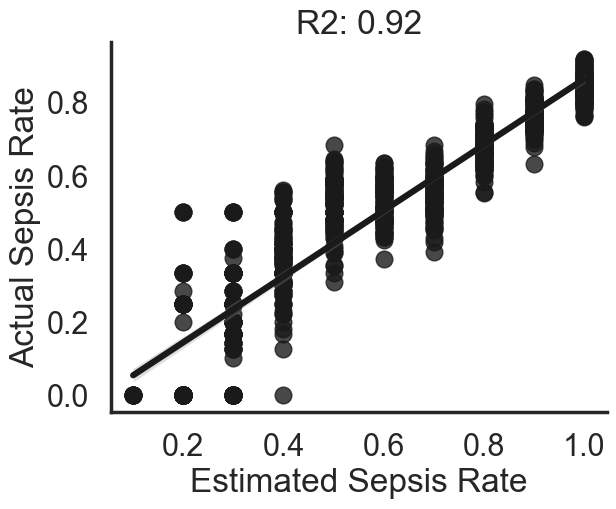

In [44]:
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

bootstrap_results = {}

from sklearn.utils import shuffle

for bootstrap in range(100):

    X_sample = X_subset.sample(
        frac=0.9,
        replace=False,
        random_state=bootstrap
    )

    protein_scaler = StandardScaler()

    X_sample[selected_features] = protein_scaler.fit_transform(X_sample[selected_features])

    X_test_subset = X_test.copy()

    X_test_subset[selected_features] = protein_scaler.transform(X_test_subset[selected_features])


    #X_sample = X.copy()

    neighbors = NearestNeighbors(
        n_neighbors=10, #round(design_matrix.shape[0] * 0.01),
        metric="euclidean"
        #p=4
    )

    neighbors.fit(X_sample[selected_features])
    distances, knn_results = neighbors.kneighbors(X_test_subset[selected_features], return_distance=True)

    neighborhood_sizes = []

    mean_distance = []

    mortality_30s = []
    mortality_30_prob = []


    for i in range(knn_results.shape[0]):

        #if distances[i].max() < distances.mean():

        knn_idx = knn_results[i, :]

        if knn_idx.size > 0:

            neighborhood = X_sample.iloc[knn_idx, :].copy()

            neighborhood_sizes.append(neighborhood.shape[0])

            mean_distance.append(
                distances[i].mean()
            )

            mortality_30 = np.where(neighborhood['sepsis_or_septic_shock'] == 1, 1, 0)

            mortality_probability_30 = mortality_30.sum() / neighborhood.shape[0]

            mortality_30s.append(mortality_30)
            mortality_30_prob.append(mortality_probability_30)

    
    bootstrap_results[f"bootstrap_{bootstrap}"] = mortality_30_prob


X_test_results = pd.concat([design_matrix_test,  pd.DataFrame(bootstrap_results)], axis=1)

fig, ax = plt.subplots()

protein_estimated_sepsis, protein_linregress_results, protein_predictions, protein_corr, protein_pval = plot_results(X_test_results, bootstrap_results)


sns.regplot(
    data=protein_estimated_sepsis,
    x="Estimated Sepsis Rate",
    y="Actual Sepsis Rate",
    ax=ax,
    color="k"
)

ax.set_title(
    f"R2: {protein_linregress_results.rvalue:.2f}"
)

sns.despine()

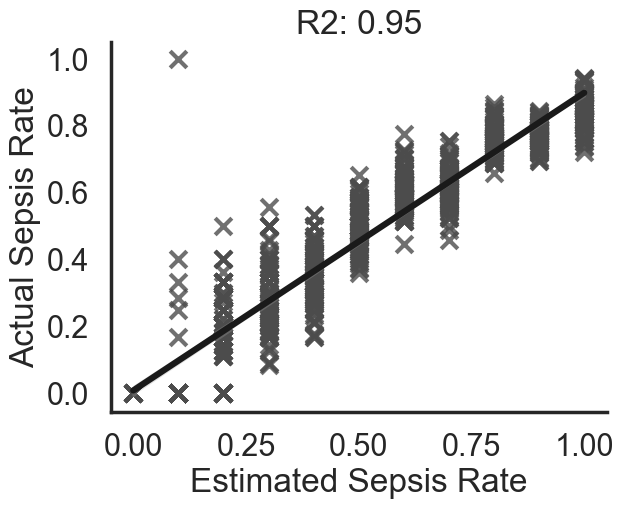

In [45]:
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.neighbors import NearestNeighbors

bootstrap_results = {}

from sklearn.utils import shuffle

for bootstrap in range(100):

    X_sample = X_subset.sample(
        frac=0.9,
        replace=False,
        random_state=bootstrap
    )

    clinical_scaler = StandardScaler()

    clinical_imputer = SimpleImputer()
    constant_imputer = SimpleImputer(strategy="constant", fill_value=0.0)

    X_sample[continuous_clinical_columns] = clinical_imputer.fit_transform(X_sample[continuous_clinical_columns])
    X_sample[categorical_clinical_columns] = constant_imputer.fit_transform(X_sample[categorical_clinical_columns])

    X_sample[continuous_clinical_columns] = clinical_scaler.fit_transform(X_sample[continuous_clinical_columns])

    X_test_subset = X_test.copy()

    X_test_subset[continuous_clinical_columns] = clinical_imputer.transform(X_test_subset[continuous_clinical_columns])
    X_test_subset[categorical_clinical_columns] = constant_imputer.transform(X_test_subset[categorical_clinical_columns])

    X_test_subset[continuous_clinical_columns] = clinical_scaler.transform(X_test_subset[continuous_clinical_columns])

    #X_sample = X.copy()

    neighbors = NearestNeighbors(
        n_neighbors=10, #round(design_matrix.shape[0] * 0.01),
        metric="euclidean"
        #p=4
    )

    neighbors.fit(X_sample[clinical_columns])
    distances, knn_results = neighbors.kneighbors(X_test_subset[clinical_columns], return_distance=True)

    neighborhood_sizes = []

    mean_distance = []

    mortality_30s = []
    mortality_30_prob = []


    for i in range(knn_results.shape[0]):

        #if distances[i].max() < distances.mean():

        knn_idx = knn_results[i, :]

        if knn_idx.size > 0:

            neighborhood = X_sample.iloc[knn_idx, :].copy()

            neighborhood_sizes.append(neighborhood.shape[0])

            mean_distance.append(
                distances[i].mean()
            )

            mortality_30 = np.where(neighborhood['sepsis_or_septic_shock'] == 1, 1, 0)

            mortality_probability_30 = mortality_30.sum() / neighborhood.shape[0]

            mortality_30s.append(mortality_30)
            mortality_30_prob.append(mortality_probability_30)

    
    bootstrap_results[f"bootstrap_{bootstrap}"] = mortality_30_prob


X_test_results = pd.concat([design_matrix_test,  pd.DataFrame(bootstrap_results)], axis=1)

fig, ax = plt.subplots()

clinical_estimated_sepsis, clinical_linregress_results, clinical_predictions, clinical_corr, clinical_pval = plot_results(X_test_results, bootstrap_results)


sns.regplot(
    data=clinical_estimated_sepsis,
    x="Estimated Sepsis Rate",
    y="Actual Sepsis Rate",
    ax=ax,
    color=".3",
    marker="x",
    line_kws=dict(color="k")
)

ax.set_title(
    f"R2: {clinical_linregress_results.rvalue:.2f}"
)

sns.despine()

In [46]:
clinical_columns.extend(selected_features)
clinical_columns

['sao2_ambulance',
 'resp_frequency_ambulance',
 'heart_rate_ambulance',
 'syst_bp_ambulance',
 'map_ambulance',
 'mental_status_ambulance',
 'temperature_ambulance',
 'crea_emergency_department',
 'bili_emergency_department',
 'crp_day1',
 'trc_emergency_department',
 'sex',
 'age',
 'VWF_HUMAN',
 'CRP_HUMAN',
 'LBP_HUMAN',
 'B2MG_HUMAN',
 'VCAM1_HUMAN',
 'FIBG_HUMAN',
 'AACT_HUMAN',
 'IBP3_HUMAN',
 'THBG_HUMAN',
 'FGL1_HUMAN']

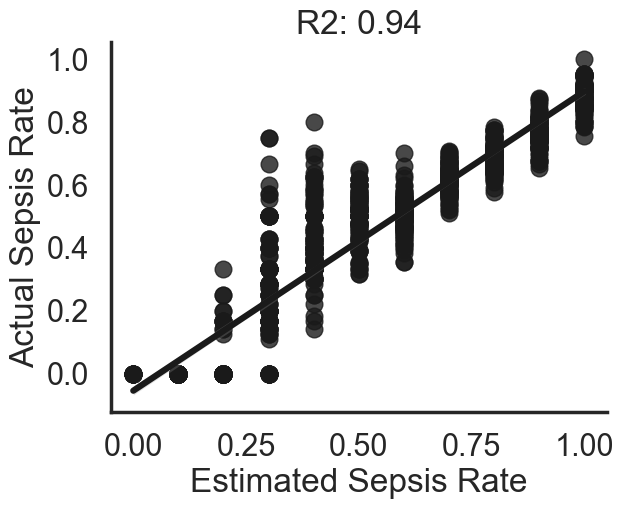

In [47]:
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.neighbors import NearestNeighbors

bootstrap_results = {}

from sklearn.utils import shuffle

for bootstrap in range(100):

    X_sample = X_subset.sample(
        frac=0.9,
        replace=False,
        random_state=bootstrap
    )

    clinical_scaler = StandardScaler()

    clinical_imputer = SimpleImputer()
    constant_imputer = SimpleImputer(strategy="constant", fill_value=0.0)

    X_sample[continuous_clinical_columns] = clinical_imputer.fit_transform(X_sample[continuous_clinical_columns])
    X_sample[categorical_clinical_columns] = constant_imputer.fit_transform(X_sample[categorical_clinical_columns])

    X_sample[continuous_clinical_columns] = clinical_scaler.fit_transform(X_sample[continuous_clinical_columns])

    X_test_subset = X_test.copy()

    X_test_subset[continuous_clinical_columns] = clinical_imputer.transform(X_test_subset[continuous_clinical_columns])
    X_test_subset[categorical_clinical_columns] = constant_imputer.transform(X_test_subset[categorical_clinical_columns])

    X_test_subset[continuous_clinical_columns] = clinical_scaler.transform(X_test_subset[continuous_clinical_columns])


    protein_scaler = StandardScaler()

    X_sample[selected_features] = protein_scaler.fit_transform(X_sample[selected_features])
    X_test_subset[selected_features] = protein_scaler.transform(X_test_subset[selected_features])

    #X_sample = X.copy()

    neighbors = NearestNeighbors(
        n_neighbors=10, #round(design_matrix.shape[0] * 0.01),
        metric="euclidean"
        #p=4
    )

    neighbors.fit(X_sample[clinical_columns])
    distances, knn_results = neighbors.kneighbors(X_test_subset[clinical_columns], return_distance=True)

    neighborhood_sizes = []

    mean_distance = []

    mortality_30s = []
    mortality_30_prob = []


    for i in range(knn_results.shape[0]):

        #if distances[i].max() < distances.mean():

        knn_idx = knn_results[i, :]

        if knn_idx.size > 0:

            neighborhood = X_sample.iloc[knn_idx, :].copy()

            neighborhood_sizes.append(neighborhood.shape[0])

            mean_distance.append(
                distances[i].mean()
            )

            mortality_30 = np.where(neighborhood['sepsis_or_septic_shock'] == 1, 1, 0)

            mortality_probability_30 = mortality_30.sum() / neighborhood.shape[0]

            mortality_30s.append(mortality_30)
            mortality_30_prob.append(mortality_probability_30)

    
    bootstrap_results[f"bootstrap_{bootstrap}"] = mortality_30_prob


X_test_results = pd.concat([design_matrix_test,  pd.DataFrame(bootstrap_results)], axis=1)

fig, ax = plt.subplots()

combined_estimated_sepsis, combined_linregress_results, combined_predictions, combined_corr, combined_pval = plot_results(X_test_results, bootstrap_results)

sns.regplot(
    data=combined_estimated_sepsis,
    x="Estimated Sepsis Rate",
    y="Actual Sepsis Rate",
    ax=ax,
    color="k"
)

ax.set_title(
    f"R2: {combined_linregress_results.rvalue:.2f}"
)

sns.despine()

In [48]:
combined_estimated_sepsis

,Actual Sepsis Rate,Estimated Sepsis Rate,Counts
0,0.000000,0.1,1
1,0.142857,0.2,7
2,0.285714,0.3,7
3,0.454545,0.4,11
4,0.428571,0.5,28
...,...,...,...
5,0.468750,0.6,32
6,0.557692,0.7,52
7,0.725806,0.8,62
8,0.772727,0.9,44


In [49]:
protein_estimated_sepsis['Label'] = "Protein"
clinical_estimated_sepsis['Label'] = "Clinical"
combined_estimated_sepsis['Label'] = "Combined"

In [50]:
protein_estimated_sepsis['Predictions'] = protein_predictions
clinical_estimated_sepsis['Predictions'] = clinical_predictions
combined_estimated_sepsis['Predictions'] = combined_predictions
combined_estimated_sepsis

,Actual Sepsis Rate,Estimated Sepsis Rate,Counts,Label,Predictions
0,0.000000,0.1,1,Combined,0.041152
1,0.142857,0.2,7,Combined,0.136251
2,0.285714,0.3,7,Combined,0.231349
3,0.454545,0.4,11,Combined,0.326448
4,0.428571,0.5,28,Combined,0.421546
...,...,...,...,...,...
5,0.468750,0.6,32,Combined,0.516645
6,0.557692,0.7,52,Combined,0.611743
7,0.725806,0.8,62,Combined,0.706842
8,0.772727,0.9,44,Combined,0.801940


In [51]:
# protein_estimated_s = protein_estimated_sepsis[['Estimated Sepsis Rate', 'Actual Sepsis Rate', 'Predictions']].groupby('Estimated Sepsis Rate').mean().reset_index()
# protein_estimated_s['Label'] = "Protein"

In [52]:
# clinical_estimated_s = clinical_estimated_sepsis[['Estimated Sepsis Rate', 'Actual Sepsis Rate', 'Predictions']].groupby('Estimated Sepsis Rate').mean().reset_index()
# clinical_estimated_s['Label'] = "Clinical"

In [53]:
# combined_estimated_s = combined_estimated_sepsis[['Estimated Sepsis Rate', 'Actual Sepsis Rate', 'Predictions']].groupby('Estimated Sepsis Rate').mean().reset_index()
# combined_estimated_s['Label'] = "Combined"

In [54]:
estimated_sepsis = pd.concat(
    [
        protein_estimated_sepsis,
        clinical_estimated_sepsis,
        combined_estimated_sepsis
    ]
)
estimated_sepsis

,Actual Sepsis Rate,Estimated Sepsis Rate,Counts,Label,Predictions
0,0.200000,0.2,5,Protein,0.144058
1,0.000000,0.3,2,Protein,0.234192
2,0.312500,0.4,16,Protein,0.324327
3,0.565217,0.5,23,Protein,0.414462
4,0.565217,0.6,23,Protein,0.504597
...,...,...,...,...,...
5,0.468750,0.6,32,Combined,0.516645
6,0.557692,0.7,52,Combined,0.611743
7,0.725806,0.8,62,Combined,0.706842
8,0.772727,0.9,44,Combined,0.801940


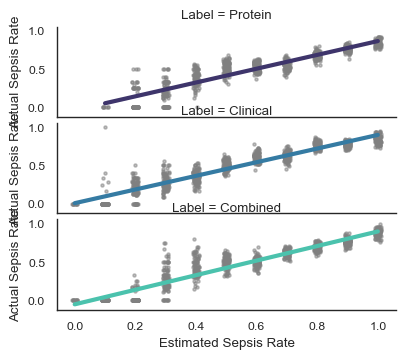

In [55]:
#fig, ax = plt.subplots()

sns.set_theme(context="paper", style="white")

g = sns.lmplot(
    data=estimated_sepsis,
    x="Estimated Sepsis Rate",
    y="Actual Sepsis Rate",
    hue="Label",
    row="Label",
    ci=95,
    palette="mako",
    scatter_kws={"color": "gray", "alpha": 0.5, "s": 5},
    line_kws={"lw": "3"},
    #scatter_kws={'alpha': 0.1, 's': 5},
    scatter=True,
    x_ci=95,
    x_jitter=0.01,
    #s=100,
    #ax=ax
)

# sns.lineplot(
#     data=estimated_sepsis,
#     x='Estimated Sepsis Rate',
#     y="Predictions",
#     hue="Label",
#     palette="mako",
#     lw=2,
#     ax=ax
# )

#g.axes[0].axline((0, 0), slope=1, color='k', linestyle='--')

sns.despine()

# ax.set_title(
#     f"R2: {combined_linregress_results.rvalue:.2f}\n
#     "
# )

g.figure.set_size_inches((4, 3))


In [56]:
g.figure.savefig(
    "digital_family_sepsis.pdf", dpi=300, bbox_inches="tight"
)